add installation cell at the top

In [17]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import compiam

In [18]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(
    tf.config.threading.get_intra_op_parallelism_threads() or 0
)
tf.config.threading.set_inter_op_parallelism_threads(2)
# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Gaud Malhar/Gaud Malhar_9.mp3'
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/solost.mp3'
fusion = False  # whether song is fusion or pure classical
output_dir = 'separated_stems'        # saved stems directory
instrument_mode = 'autodetect'

filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir, codec='mp3')
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.mp3')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.mp3')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)

Skipping separation: 'separated_stems/solost' already exists.
Vocals: separated_stems/solost/vocals.mp3
Accompaniment: separated_stems/solost/accompaniment.mp3


-------Vocal analysis--------
[LOAD CSV] vocals_pitch_data.csv -> PitchResult (frames=28943, voiced=6236)
[INFO] Applied override confidence threshold = 0.98


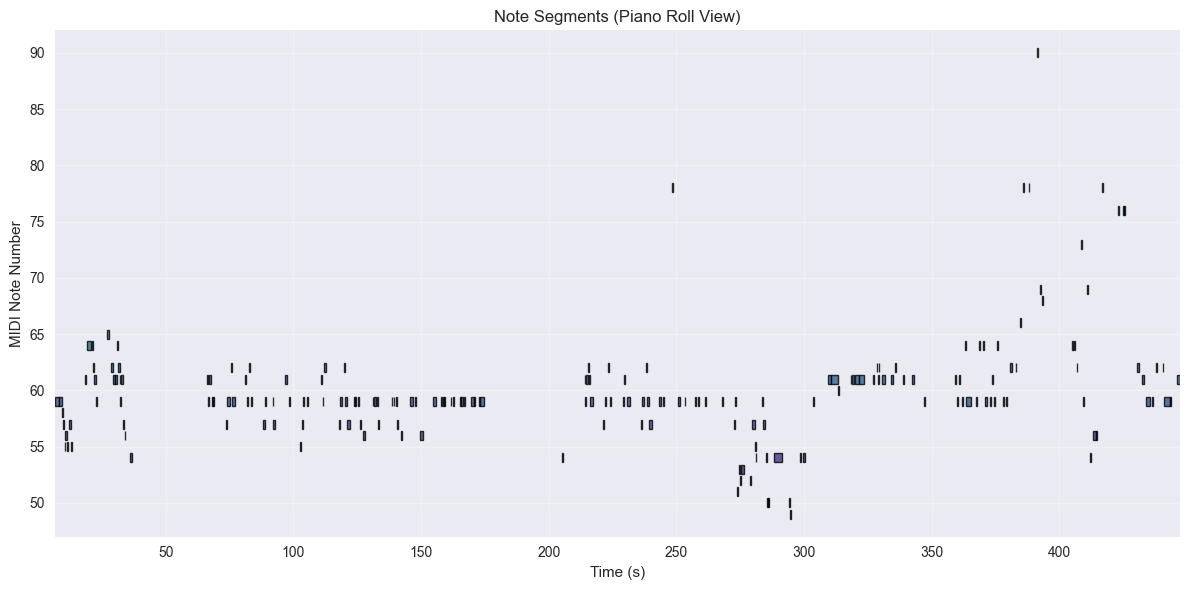

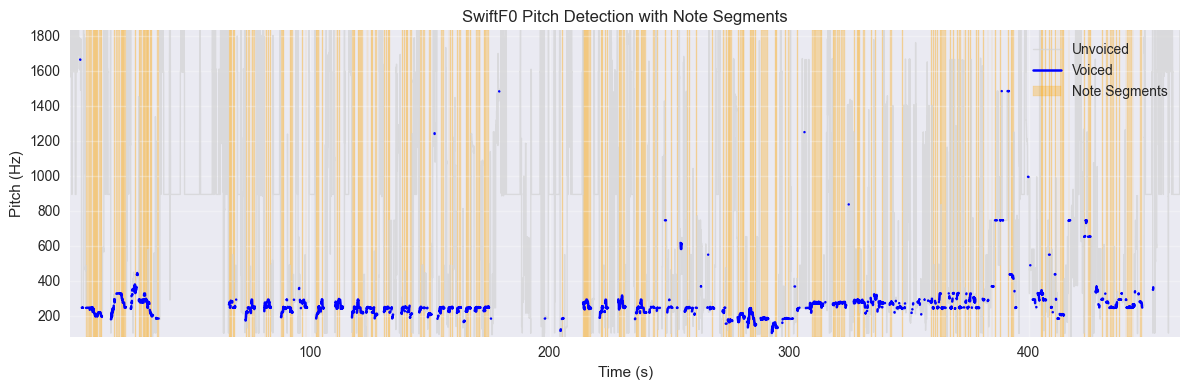

[LOAD] MIDI npy loaded: separated_stems/solost/vocals_midi.npy (len=9674)

vocals — voiced (valid) frames: 9674
MIDI preview (first up to 40): [92.04000091552734, 92.04000091552734, 92.04000091552734, 92.02999877929688, 59.04999923706055, 59.04999923706055, 59.040000915527344, 59.029998779296875, 59.02000045776367, 59.0099983215332, 59.0, 58.9900016784668, 59.0, 59.0099983215332, 59.0099983215332, 59.0, 59.0, 58.9900016784668, 58.97999954223633, 58.97999954223633, 58.97999954223633, 58.9900016784668, 58.9900016784668, 58.9900016784668, 59.0, 59.0099983215332, 59.0, 59.0, 59.0, 59.02000045776367, 59.04999923706055, 59.060001373291016, 58.93000030517578, 58.93000030517578, 58.939998626708984, 58.95000076293945, 58.959999084472656, 58.970001220703125, 58.970001220703125, 58.97999954223633]
Unique pitch-classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 59.60, median 59.01, std 4.81



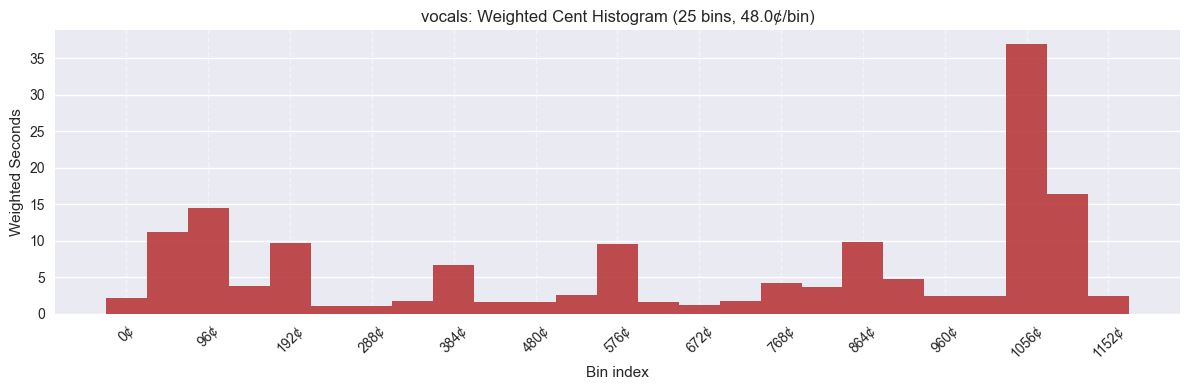

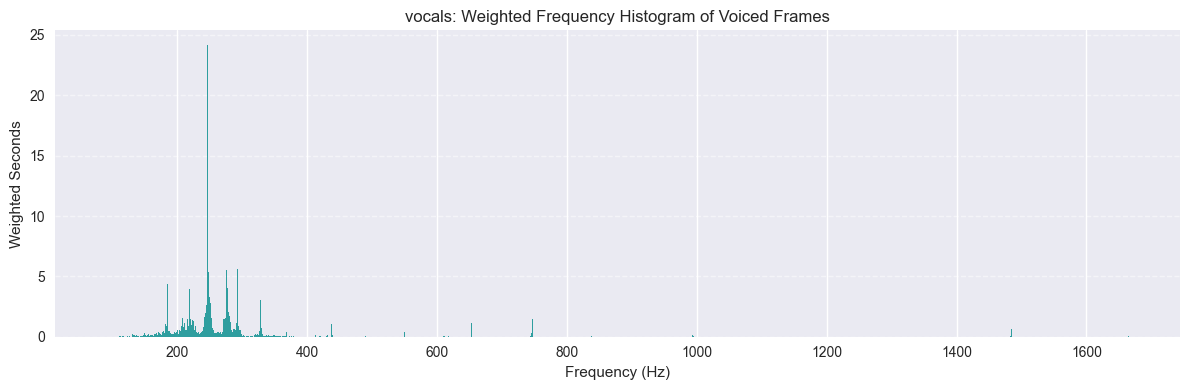

-------Accompaniment analysis --------
[LOAD CSV] accompaniment_pitch_data.csv -> PitchResult (frames=28943, voiced=12622)


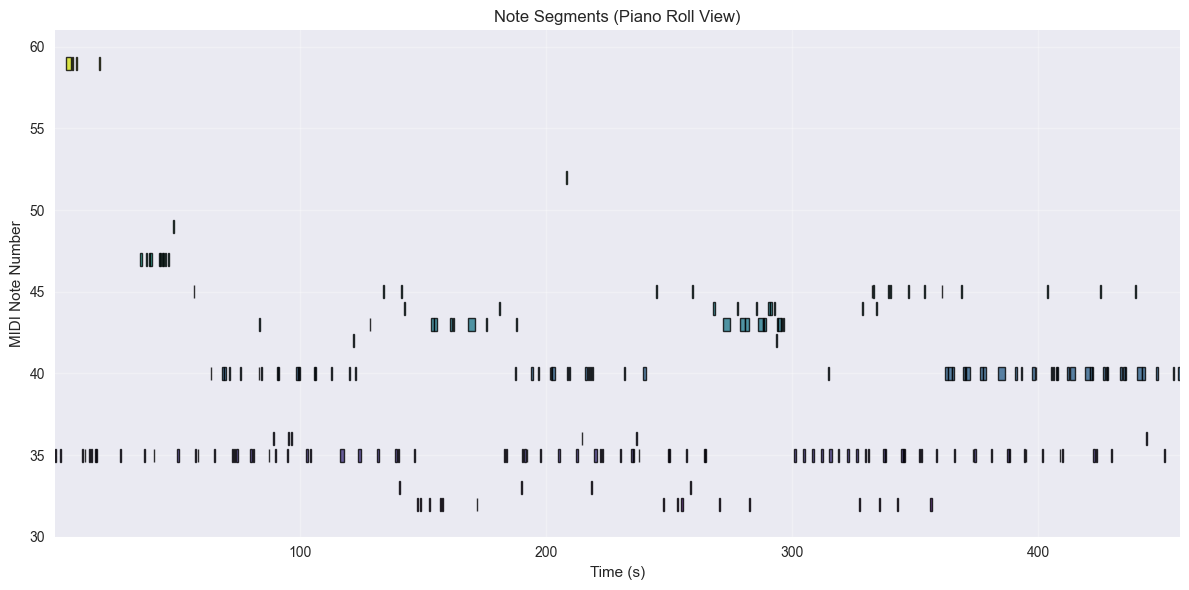

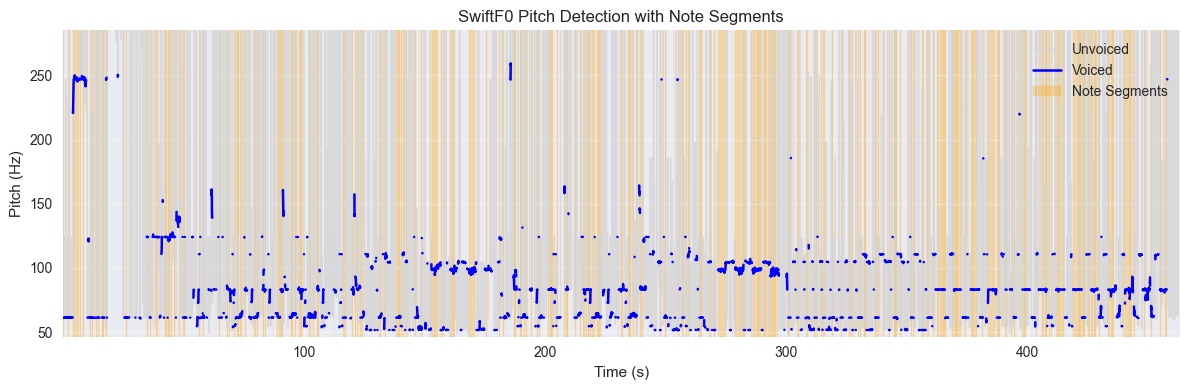

[LOAD] MIDI npy loaded: separated_stems/solost/accompaniment_midi.npy (len=12622)

accompaniment — voiced (valid) frames: 12622
MIDI preview (first up to 40): [34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156, 34.86000061035156]
Unique pitch-classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 39.44, me

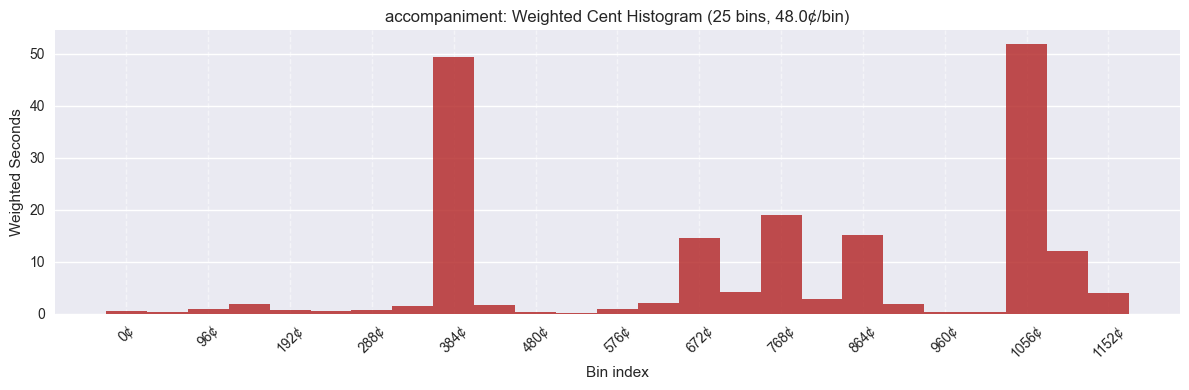

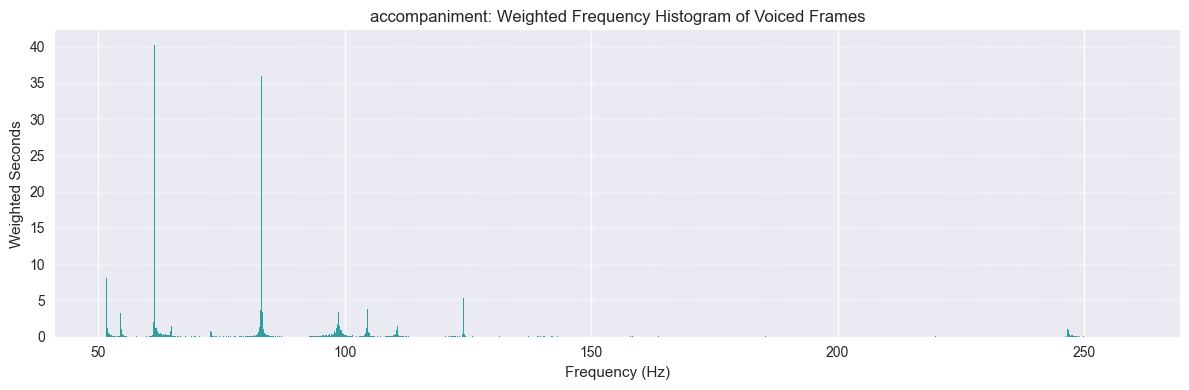

In [19]:
from swift_f0 import (
    SwiftF0,
    PitchResult,
    plot_pitch,
    export_to_csv,
    segment_notes,
    plot_notes,
    plot_pitch_and_notes,
    export_to_midi
)

def load_swiftf0_csv_as_pitchresult(csv_path, silent=False):
    df = pd.read_csv(csv_path)
    # accept 'time' or 'timestamp' for timing, 'voiced' or 'voicing' for voiced flag
    ts_col = None
    if 'time' in df.columns:
        ts_col = 'time'
    elif 'timestamp' in df.columns:
        ts_col = 'timestamp'

    pitch_col = 'pitch_hz' if 'pitch_hz' in df.columns else None
    conf_col = 'confidence' if 'confidence' in df.columns else None
    voiced_col = 'voicing' if 'voicing' in df.columns else ('voiced' if 'voiced' in df.columns else None)

    if pitch_col is None or conf_col is None:
        raise ValueError(f"CSV {csv_path} missing required columns. Found: {list(df.columns)}")

    timestamps = pd.to_numeric(df[ts_col], errors='coerce').to_numpy() if ts_col else np.arange(len(df)).astype(float)
    pitch_hz = pd.to_numeric(df[pitch_col], errors='coerce').to_numpy()
    pitch_hz = np.nan_to_num(pitch_hz, nan=0.0)
    confidence = pd.to_numeric(df[conf_col], errors='coerce').to_numpy()
    confidence = np.nan_to_num(confidence, nan=0.0)

    if voiced_col:
        voiced_raw = df[voiced_col].astype(str).fillna('').str.strip().str.lower()
        def parse_bool(x):
            if x == '' or x == 'nan':
                return False
            if x in ('1','1.0','true','t','yes','y'):
                return True
            if x in ('0','0.0','false','f','no','n'):
                return False
            try:
                return bool(int(float(x)))
            except Exception:
                return False
        voiced = np.array([parse_bool(x) for x in voiced_raw], dtype=bool)
    else:
        voiced = (pitch_hz > 0) & (confidence > 0)

    # frame_period if available via 'frame_rate' or infer from timestamps
    frame_period = None
    if 'frame_rate' in df.columns:
        try:
            frame_period = 1.0 / float(df['frame_rate'].iloc[0])
        except Exception:
            frame_period = None
    elif ts_col:
        times = pd.to_numeric(df[ts_col], errors='coerce').to_numpy()
        if len(times) > 1:
            diffs = np.diff(times[:min(50, len(times))])
            frame_period = float(np.median(diffs)) if diffs.size else None

    pr = PitchResult(pitch_hz=pitch_hz, confidence=confidence, timestamps=timestamps, voicing=voiced)
    # attach frame_period attribute for compatibility
    setattr(pr, 'frame_period', frame_period)
    if not silent:
        print(f"[LOAD CSV] {os.path.basename(csv_path)} -> PitchResult (frames={len(pitch_hz)}, voiced={int(voiced.sum())})")
    return pr

def analyze_or_load_with_plots(stem_path, detector, output_prefix="output",
                              num_bins=25, save_midi=True, force_recompute=False,
                              store_as_vocal=False, override_confidence_threshold=None):
    global vocal_note_sequence

    stem_dir = os.path.dirname(stem_path) or "."
    csv_path = os.path.join(stem_dir, f"{output_prefix}_pitch_data.csv")
    midi_npy_path = os.path.join(stem_dir, f"{output_prefix}_midi.npy")
    midi_csv_path = os.path.join(stem_dir, f"{output_prefix}_midi.csv")

    pr = None
    sr = None

    # 1) Load CSV or run detection
    if os.path.isfile(csv_path) and not force_recompute:
        try:
            pr = load_swiftf0_csv_as_pitchresult(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to load CSV {csv_path}: {e}. Will recompute.")
            pr = None

    if pr is None:
        # run SwiftF0 on the stem and export CSV
        print(f"[RUN] No CSV or force_recompute -> running SwiftF0 for {stem_path}")
        y, sr = librosa.load(stem_path, sr=None, duration=600.0)
        pr = detector.detect_from_array(y, sr)
        try:
            export_to_csv(pr, csv_path)
            print(f"[WRITE] Exported CSV: {csv_path}")
        except Exception as e:
            print(f"[WARN] export_to_csv failed: {e}")

    # ----------------------------------------------------------------
    # >>> MINIMAL INSERT: allow overriding voicing threshold on-the-fly
    if override_confidence_threshold is not None:
        voiced = (pr.pitch_hz > 0) & (pr.confidence >= override_confidence_threshold)
        setattr(pr, "voicing", voiced)
        print(f"[INFO] Applied override confidence threshold = {override_confidence_threshold}")
    # ----------------------------------------------------------------

    # Plot pitch (always run to get updated visuals)
    try:
        plot_pitch(pr, show=False, output_path=os.path.join(stem_dir, f"{output_prefix}_pitch.jpg"))
    except Exception as e:
        print(f"[WARN] plot_pitch failed: {e}")

    # note segmentation + plots + MIDI export
    notes = []
    try:
        notes = segment_notes(pr, split_semitone_threshold=0.8, min_note_duration=0.25)

        if store_as_vocal:
            vocal_note_sequence = [
                {
                    "start": note.start,
                    "end": note.end,
                    "pitch_hz": note.pitch_median,
                    "midi_note": note.pitch_midi
                }
                for note in notes
            ]
        try:
            plot_notes(notes, output_path=os.path.join(stem_dir, f"{output_prefix}_note_segments.jpg"))
        except Exception as e:
            print(f"[WARN] plot_notes failed: {e}")
        try:
            plot_pitch_and_notes(pr, notes, output_path=os.path.join(stem_dir, f"{output_prefix}_combined_analysis.jpg"))
        except Exception as e:
            print(f"[WARN] plot_pitch_and_notes failed: {e}")
        try:
            export_to_midi(notes, os.path.join(stem_dir, f"{output_prefix}_notes.mid"))
        except Exception as e:
            print(f"[WARN] export_to_midi failed: {e}")
    except Exception as e:
        print(f"[WARN] segment_notes failed or returned no notes: {e}")
        notes = []

    # extract voiced frames robustly
    voiced_mask = getattr(pr, 'voicing', None)
    pitch_hz_arr = getattr(pr, 'pitch_hz', np.array([], dtype=float))
    conf_arr = getattr(pr, 'confidence', None)

    if voiced_mask is not None and len(voiced_mask) == len(pitch_hz_arr):
        voiced_freqs = pitch_hz_arr[voiced_mask]
        voiced_confs = conf_arr[voiced_mask] if conf_arr is not None else np.ones_like(voiced_freqs)
    else:
        voiced_freqs = pitch_hz_arr
        voiced_confs = conf_arr if conf_arr is not None else np.ones_like(voiced_freqs)

    # filter positives
    valid_mask = voiced_freqs > 0
    valid_frequencies = voiced_freqs[valid_mask]
    valid_confidences = voiced_confs[valid_mask] if np.size(voiced_confs) else np.array([])

    # frame duration
    frame_period = getattr(pr, 'frame_period', None)
    if frame_period is None:
        if sr is not None:
            frame_period = 512.0 / float(sr)
        else:
            frame_period = 0.01
    weights = (valid_confidences * frame_period) if valid_confidences.size else np.array([])

    # MIDI values (load or compute and save)
    midi_vals = None
    if save_midi and os.path.isfile(midi_npy_path) and not force_recompute:
        try:
            midi_vals = np.load(midi_npy_path)
            print(f"[LOAD] MIDI npy loaded: {midi_npy_path} (len={len(midi_vals)})")
        except Exception as e:
            print(f"[WARN] Failed to load MIDI npy: {e}. Will recompute MIDI.")
            midi_vals = None

    if midi_vals is None:
        if valid_frequencies.size:
            midi_vals = librosa.hz_to_midi(valid_frequencies)
        else:
            midi_vals = np.array([], dtype=float)
        if save_midi:
            try:
                np.save(midi_npy_path, midi_vals)
                pd.DataFrame({"midi": np.round(midi_vals, 6)}).to_csv(midi_csv_path, index=False)
                print(f"[WRITE] Saved MIDI -> {midi_npy_path}, {midi_csv_path}")
            except Exception as e:
                print(f"[WARN] Failed to save MIDI files: {e}")

    #  MIDI summary
    if midi_vals.size:
        midi_preview = np.round(midi_vals[:40], 2).tolist()
        pitch_classes = np.mod(np.round(midi_vals), 12).astype(int)
        print(f"\n{output_prefix} — voiced (valid) frames: {len(midi_vals)}")
        print("MIDI preview (first up to 40):", midi_preview)
        print("Unique pitch-classes:", sorted(np.unique(pitch_classes).tolist()))
        print("MIDI mean {:.2f}, median {:.2f}, std {:.2f}\n".format(np.mean(midi_vals), np.median(midi_vals), np.std(midi_vals)))
    else:
        print(f"\n{output_prefix} — no valid voiced frames found. MIDI empty.\n")

    # cent histogram (weighted) and save plots
    if valid_frequencies.size:
        midi_vals_full = librosa.hz_to_midi(valid_frequencies)
        cent_values = (midi_vals_full % 12) * 100.0
        cent_hist, _ = np.histogram(cent_values, bins=num_bins, range=(0, 1200), weights=weights if weights.size else None)
    else:
        cent_hist = np.zeros(num_bins, dtype=float)

    bin_width = 1200.0 / num_bins
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, color='firebrick', alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_cent_histogram.jpg"))
    plt.show()
    plt.close()

    # frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(valid_frequencies, bins=1200, color='darkcyan', alpha=0.8, weights=weights if weights.size else None)
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_frequency_histogram.jpg"))
    plt.show()
    plt.close()

    return pr, valid_frequencies, cent_hist, midi_vals

min_note_str = 'G1'
max_note_str = 'C4'
fmin_hz = librosa.note_to_hz(min_note_str)
fmax_hz = librosa.note_to_hz(max_note_str)

detector_v = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)
print("-------Vocal analysis--------")
result_v, valid_freqs_v, cent_hist_v, midi_vals_v = analyze_or_load_with_plots(
    vocals_path,
    detector_v,
    output_prefix="vocals",
    store_as_vocal=True,
    override_confidence_threshold=0.98   # play with this freely
)


detector_a = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
print("-------Accompaniment analysis --------")
result_a, valid_freqs_a, cent_hist_a, midi_vals_a = analyze_or_load_with_plots(accompaniment_path, detector_a, output_prefix="accompaniment")


Successfully built the new interval-based rāga database.
Computed high-resolution histogram with shape: (100,)
Computed low-resolution histogram with shape: (33,)
[PEAKS] high-res smoothed: found 6 peaks (prom=32.22, dist=2)
[MINIMA] high-res smoothed: found 6 minima (prom>=21.22, dist=2)
[INFO] Pitch classes with peaks: [1, 2, 4, 6, 9, 11]
[INFO] Pitch classes with minima only (no peaks): [3, 5, 7, 10]
[PEAKS] low-res: found 7 peaks (prom=25.75)
[DEBUG] high-res peak sample (idx, cents, count, prom):
  idx=8, cents=102.0, count=344.0, prom=310.00
  idx=16, cents=198.0, count=247.0, prom=194.00
  idx=32, cents=390.0, count=164.0, prom=145.00
  idx=50, cents=606.0, count=214.0, prom=197.00
  idx=74, cents=894.0, count=182.0, prom=156.00
  idx=91, cents=1098.0, count=1074.0, prom=1044.00
Generating *normalized* histogram plot with western-note x-axis and ±35¢ note zones...


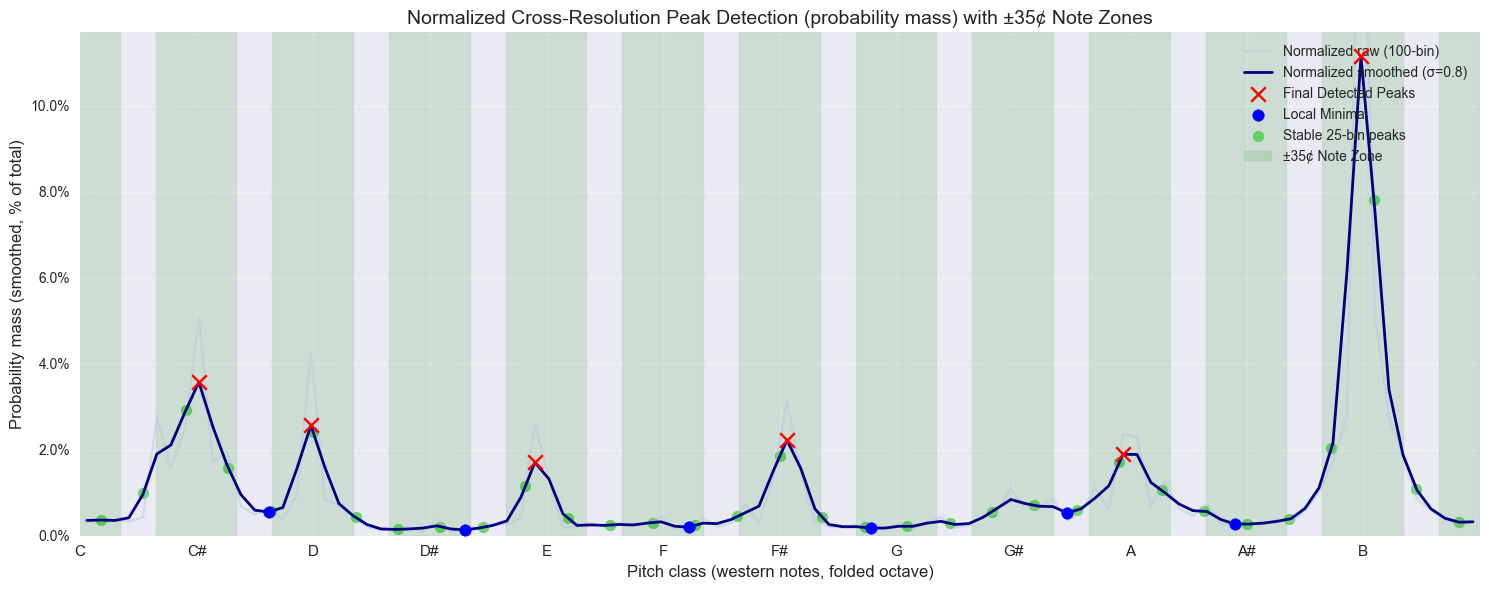

[INFO] detected_peak_count = 6

Found 6 precise peaks (100-bin) and 7 stable regions (25-bin).
Validated 6 final peaks.
Pitch-class candidates passed to next stage (±35¢ rule): [1, 2, 4, 6, 9, 11]


In [25]:
from collections import defaultdict
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d

# canonical form: lexicographically smallest rotation of the pattern
def get_canonical_intervals(intervals):
    if not isinstance(intervals, tuple) or not intervals:
        return tuple()
    return min(tuple(np.roll(intervals, i)) for i in range(len(intervals)))

# load processed raga hash table
raga_df = pd.read_csv('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/db/raga_list_final.csv')

# build lookup: canonical interval pattern → list of matching ragas
raga_interval_db = defaultdict(list)

for _, row in raga_df.iterrows():
    if 'mask' in raga_df.columns:
        mask_abs = tuple(map(int, row['mask'].split(',')))
        name = row['raga']
    else:
        mask_abs = tuple(int(row[str(i)]) for i in range(12))
        name = row['names']

    p = np.where(np.array(mask_abs) == 1)[0]
    if len(p) < 2:
        continue
    p.sort()
    intervals = tuple(np.mod(np.diff(np.concatenate((p, [p[0] + 12]))), 12))
    if sum(intervals) != 12:
        continue
    canonical_pattern = get_canonical_intervals(intervals)
    raga_interval_db[canonical_pattern].append({'name': name, 'intervals': intervals})

raga_masks = raga_interval_db
print("Successfully built the new interval-based rāga database.")

# compute high- and low-resolution histograms
num_bins_high_res = 100
num_bins_low_res = 33
sigma = 0.8

midi_vals_mel = librosa.hz_to_midi(valid_freqs_v)
cent_values = (midi_vals_mel % 12) * 100

H_mel_100, bin_edges_100 = np.histogram(cent_values, bins=num_bins_high_res, range=(0, 1200))
H_mel_25, bin_edges_25 = np.histogram(cent_values, bins=num_bins_low_res, range=(0, 1200))

print(f"Computed high-resolution histogram with shape: {H_mel_100.shape}")
print(f"Computed low-resolution histogram with shape: {H_mel_25.shape}")



# ---------------- Replacement for "part a: find peaks in both histograms and convert to cents" --------------
from scipy.signal import find_peaks, peak_prominences

# smoothed_H_100 and bin_centers_100 already computed above
smoothed_H_100 = gaussian_filter1d(H_mel_100, sigma=sigma, mode='wrap')
bin_centers_100 = (bin_edges_100[:-1] + bin_edges_100[1:]) / 2.0

# helper: circular-aware peak finder using scipy.find_peaks
def find_circular_peaks(arr, prominence=None, distance=None, height=None):
    n = len(arr)
    peaks, props = find_peaks(arr, prominence=prominence, distance=distance, height=height)
    peaks = list(peaks)

    # simple wrap checks for index 0 and n-1 (find_peaks treats array as linear)
    if n >= 2:
        if 0 not in peaks and arr[0] > arr[1] and arr[0] > arr[-1]:
            peaks.append(0)
        if (n - 1) not in peaks and arr[-1] > arr[-2] and arr[-1] > arr[0]:
            peaks.append(n - 1)

    peaks = sorted(set(peaks))
    prominences = peak_prominences(arr, peaks)[0] if peaks else np.array([])
    return np.array(peaks, dtype=int), props, prominences

# helper: more robust circular minima using array extension around the seam
# detects maxima on -arr in an extended array and maps them back, deduplicating by highest prominence

def find_circular_minima_extended(arr, prominence=None, distance=None):
    n = len(arr)
    pad = max(int(distance or 1), 3)
    ext = np.concatenate([arr[-pad:], arr, arr[:pad]])
    # find maxima on the negated extended signal
    peaks_ext, _ = find_peaks(-ext, prominence=prominence, distance=distance, height=None)
    if peaks_ext.size == 0:
        return np.array([], dtype=int), np.array([])
    prom_ext = peak_prominences(-ext, peaks_ext)[0]

    # map back to base indices and keep only the strongest per base bin
    best = {}
    for eidx, pval in zip(peaks_ext, prom_ext):
        base_idx = (eidx - pad) % n
        if (base_idx not in best) or (pval > best[base_idx][0]):
            best[base_idx] = (float(pval), int(eidx))

    final_indices = np.array(sorted(best.keys()))
    final_prom = np.array([best[i][0] for i in final_indices])
    return final_indices.astype(int), final_prom

# --- parameters you can tune ---
prom_high = max(1.0, 0.03 * float(smoothed_H_100.max()))  # default: 3% of max or at least 1
dist_high = 2   # min separation in bins for high-res (2 bins ≈ 24 cents if 100 bins -> 12 semitones)
height_high = None

# find high-res peaks in smoothed histogram
smoothed_peaks_100_indices, sm_props_high, sm_high_proms = find_circular_peaks(
    smoothed_H_100, prominence=prom_high, distance=dist_high, height=height_high
)
smoothed_peaks_cents = bin_centers_100[smoothed_peaks_100_indices]
print(f"[PEAKS] high-res smoothed: found {len(smoothed_peaks_100_indices)} peaks (prom={prom_high:.2f}, dist={dist_high})")

# Also find local minima with robust circular handling across the 1200↔0 seam
min_prom = max(1.0, 0.02 * float(smoothed_H_100.max() - smoothed_H_100.min()))
min_dist = dist_high
smoothed_minima_100_indices, sm_min_proms = find_circular_minima_extended(
    smoothed_H_100, prominence=min_prom, distance=min_dist
)
smoothed_minima_cents = bin_centers_100[smoothed_minima_100_indices]
print(f"[MINIMA] high-res smoothed: found {len(smoothed_minima_100_indices)} minima (prom>={min_prom:.2f}, dist={min_dist})")

# Map detected peaks and minima to pitch classes (0-11)
note_centers = np.arange(0, 1200, 100)
tolerance_cents = 35

# Which pitch classes have peaks?
pc_with_peaks = set()
for peak_cent in smoothed_peaks_cents:
    diffs = np.abs((peak_cent - note_centers + 600) % 1200 - 600)
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_with_peaks.add(nearest_idx % 12)

# Which pitch classes have minima?
pc_with_minima = set()
for min_cent in smoothed_minima_cents:
    diffs = np.abs((min_cent - note_centers + 600) % 1200 - 600)
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_with_minima.add(nearest_idx % 12)

# Critical: pitch classes with minima BUT NO peaks
pc_minima_no_peaks = pc_with_minima - pc_with_peaks

print(f"[INFO] Pitch classes with peaks: {sorted(pc_with_peaks)}")
print(f"[INFO] Pitch classes with minima only (no peaks): {sorted(pc_minima_no_peaks)}")

# low-res histogram (25 bins)
bin_centers_25 = (bin_edges_25[:-1] + bin_edges_25[1:]) / 2.0
prom_low = max(0, 0.01 * float(H_mel_25.max()))
dist_low = 1
raw_peaks_25_indices, low_props, low_proms = find_circular_peaks(
    H_mel_25, prominence=prom_low, distance=dist_low, height=None
)
raw_peaks_cents = bin_centers_25[raw_peaks_25_indices]
print(f"[PEAKS] low-res: found {len(raw_peaks_25_indices)} peaks (prom={prom_low:.2f})")

# Print some diagnostics (optional, helpful while tuning)
if len(smoothed_peaks_100_indices):
    print("[DEBUG] high-res peak sample (idx, cents, count, prom):")
    for p_idx, p_prom in zip(smoothed_peaks_100_indices[:8], sm_high_proms[:8]):
        print(f"  idx={int(p_idx)}, cents={bin_centers_100[int(p_idx)]:.1f}, count={smoothed_H_100[int(p_idx)]:.1f}, prom={p_prom:.2f}")
# ----------------------------------------------------------------------------------------------------------


# config
note_centers = np.arange(0, 1200, 100)
tolerance_cents = 35
peak_tolerance_cents = 45

# part b: validate precise peaks using stable peaks + ±35¢ note center rule
final_peak_indices_100 = []
for i, sp_cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    is_validated = any(abs(sp_cent - rp_cent) <= peak_tolerance_cents for rp_cent in raw_peaks_cents)
    if not is_validated:
        continue
    diffs = np.abs((sp_cent - note_centers + 600) % 1200 - 600)
    if np.min(diffs) <= tolerance_cents:
        final_peak_indices_100.append(i)

import matplotlib.ticker as mtick

# normalized plotting
smoothed_H_100_norm = smoothed_H_100.astype(float)
total = smoothed_H_100_norm.sum()
if total <= 0:
    smoothed_H_100_plot = smoothed_H_100_norm
else:
    smoothed_H_100_plot = smoothed_H_100_norm / total
H_mel_100_norm = H_mel_100.astype(float) / (H_mel_100.sum() + 1e-12)

print("Generating *normalized* histogram plot with western-note x-axis and ±35¢ note zones...")

NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.figure(figsize=(15, 6))
plt.plot(bin_centers_100, H_mel_100_norm, color='lightsteelblue', alpha=0.4, label='Normalized raw (100-bin)')
plt.plot(bin_centers_100, smoothed_H_100_plot, color='navy', linewidth=2, label=f'Normalized smoothed (σ={sigma})')
peak_x_values = bin_centers_100[final_peak_indices_100]
peak_y_values_plot = smoothed_H_100_plot[final_peak_indices_100]
plt.scatter(peak_x_values, peak_y_values_plot, color='red', s=110, marker='x',
            zorder=6, label='Final Detected Peaks')

# plot local minima on the smoothed histogram in blue
if len(smoothed_minima_100_indices):
    minima_x_values = bin_centers_100[smoothed_minima_100_indices]
    minima_y_values_plot = smoothed_H_100_plot[smoothed_minima_100_indices]
    plt.scatter(minima_x_values, minima_y_values_plot, color='blue', s=70, marker='o',
                zorder=6, label='Local Minima')

low_centers = bin_centers_25
low_vals_plot = np.interp(low_centers, bin_centers_100, smoothed_H_100_plot)
plt.scatter(low_centers, low_vals_plot, color='limegreen', s=60, marker='o', alpha=0.7, label='Stable 25-bin peaks')
for idx, center in enumerate(note_centers):
    low = (center - tolerance_cents) % 1200
    high = (center + tolerance_cents) % 1200
    if low < high:
        plt.axvspan(low, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
    else:
        plt.axvspan(0, high, color='green', alpha=0.12, label='±35¢ Note Zone' if idx == 0 else "")
        plt.axvspan(low, 1200, color='green', alpha=0.12)
xticks_positions = np.arange(0, 1200, 100)
plt.xticks(ticks=xticks_positions, labels=NOTE_NAMES, fontsize=11)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylabel("Probability mass (smoothed, % of total)", fontsize=12)
plt.title("Normalized Cross-Resolution Peak Detection (probability mass) with ±35¢ Note Zones", fontsize=14)
plt.xlabel("Pitch class (western notes, folded octave)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.xlim(0, 1200)
plt.ylim(0, max(smoothed_H_100_plot.max() * 1.05, 0.01))
plt.tight_layout()
plt.show()

# part d: final output for downstream cell
final_peak_cents = bin_centers_100[final_peak_indices_100]
pc_cand = set()
for cent_val in final_peak_cents:
    diffs = np.abs((cent_val - note_centers + 600) % 1200 - 600)
    nearest_idx = np.argmin(diffs)
    if diffs[nearest_idx] <= tolerance_cents:
        pc_cand.add(nearest_idx % 12)
pc_cand = sorted(pc_cand)
cent_to_pc = np.round(bin_centers_100 / 100).astype(int) % 12
#pc_cand = sorted(list({cent_to_pc[i] for i in final_peak_indices_100}))
if 'pc_cand' in globals():
    detected_peak_count = len(pc_cand)
print(f"[INFO] detected_peak_count = {detected_peak_count}")
print(f"\nFound {len(smoothed_peaks_cents)} precise peaks (100-bin) and {len(raw_peaks_cents)} stable regions (25-bin).")
print(f"Validated {len(final_peak_indices_100)} final peaks.")
print(f"Pitch-class candidates passed to next stage (±{tolerance_cents}¢ rule): {pc_cand}")
detected_peak_count = len(pc_cand)

In [27]:
print(pc_minima_no_peaks)

{10, 3, 5, 7}


In [21]:
import pandas as pd
import numpy as np

# sanity checks
required = ['smoothed_peaks_100_indices','smoothed_peaks_cents','raw_peaks_cents',
            'final_peak_indices_100','bin_centers_100','tolerance_cents','peak_tolerance_cents']
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from earlier cells: {missing}. Run the peak-detection cell first.")

rows = []
note_centers = np.arange(0, 1200, 100)
for idx, cent in zip(smoothed_peaks_100_indices, smoothed_peaks_cents):
    # distance to nearest low-res peak (25-bin)
    dist_to_lowres = np.min(np.abs(raw_peaks_cents - cent)) if len(raw_peaks_cents) else np.nan
    near_lowres = bool(dist_to_lowres <= peak_tolerance_cents)

    # distance to nearest semitone center (circular)
    diffs = np.abs((cent - note_centers + 600.0) % 1200.0 - 600.0)
    nearest_note = int(np.argmin(diffs))
    note_dist = float(diffs[nearest_note])
    within_note_tol = note_dist <= tolerance_cents

    # whether this high-res peak was included in the final validated list
    validated = idx in set(final_peak_indices_100)

    # map to pitch-class (nearest semitone)
    pc_mapped = nearest_note % 12
    note_name_map = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    rows.append({
        'highres_bin_idx': int(idx),
        'cent_position': float(cent),
        'mapped_pc': int(pc_mapped),
        'mapped_note': note_name_map[pc_mapped],
        'dist_to_lowres_peak_cents': float(dist_to_lowres),
        'near_lowres(<=peak_tol)': near_lowres,
        'dist_to_semitone_cents': note_dist,
        'within_note_tol(<=35c)': within_note_tol,
        'validated_final': bool(validated)
    })

df_peaks = pd.DataFrame(rows).sort_values(by='cent_position')
pd.set_option('display.float_format', lambda x: f"{x:0.1f}")
print(df_peaks.to_string(index=False))


 highres_bin_idx  cent_position  mapped_pc mapped_note  dist_to_lowres_peak_cents  near_lowres(<=peak_tol)  dist_to_semitone_cents  within_note_tol(<=35c)  validated_final
               8          102.0          1          C#                       11.1                     True                     2.0                    True             True
              16          198.0          2           D                        2.0                     True                     2.0                    True             True
              32          390.0          4           E                        8.2                     True                    10.0                    True             True
              50          606.0          6          F#                        6.0                     True                     6.0                    True             True
              74          894.0          9           A                        3.1                     True                     6.0          

In [22]:
# build interval sequence from detected pitch-classes
P = np.array(pc_cand)
p = np.sort(P)
k = len(p)
intervals = np.mod(np.diff(np.concatenate((p, [p[0]+12]))), 12)
print(f"Detected intervals: {intervals}")

dx_candidates = []  # list of (tonic, mask_rel, ragas)

# p is the sorted list of detected pitch classes
# intervals is the detected interval sequence
# k is the number of detected pitch classes
for j in range(k):
    tonic = int(p[j])
    # consider each possible rotation of the detected intervals
    rotated_I = tuple(np.roll(intervals, -j))
    
    # find the canonical form of the detected interval pattern
    canonical_I = get_canonical_intervals(rotated_I)

    # look for this scale structure in our new database
    if canonical_I in raga_masks:
        # 'raga_group' contains all rāgas matching the canonical pattern (e.g., Bhupali, Dhani)
        raga_group = raga_masks[canonical_I]
        
        # Check which of these ragas has the exact interval pattern we just detected
        matching_ragas = [
            raga['name'] for raga in raga_group 
            if raga['intervals'] == rotated_I
        ]
        
        if matching_ragas:
            current_note = 0
            # notes relative to the tonic at 0
            relative_notes = {0}
            for step in rotated_I[:-1]:
                current_note += step
                relative_notes.add(current_note)
            
            mask_rel = tuple(1 if i in relative_notes else 0 for i in range(12))

            # add the found candidate to our list
            dx_candidates.append((tonic, mask_rel, matching_ragas))

print(f"Valid interval-based inversions: {[(t, ragas) for t,_,ragas in dx_candidates]}")

#  compute accompaniment tonic salience for these tonics
midi_vals_acc = librosa.hz_to_midi(valid_freqs_a)
pitch_classes_acc = np.mod(np.round(midi_vals_acc), 12).astype(int)

H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0,12))
a_theta = {t: np.roll(H_acc, -t)[0] for t,_,_ in dx_candidates}
print(f"Accompaniment salience per tonic: {a_theta}")

results = []
# aggregate melody histogram from high-resolution bins to 12 pitch classes
H_pc = np.zeros(12, dtype=int)
for bin_index, pc in enumerate(cent_to_pc):
    H_pc[pc] += H_mel_100[bin_index] 

for tonic, mask_rel, ragas in dx_candidates:
    # create Sa-relative view of the melody's pitch distribution
    H_rot = np.roll(H_pc, -tonic)
    # bonus for the tonic (Sa) is always its count in the melody
    sa_bonus = H_rot[0]
    
    bonus_options = [0] # Start with 0 in case rāga has no Ma or Pa.
    if mask_rel[5] == 1:  # Check for Shuddha Ma
        bonus_options.append(H_rot[5])
    if mask_rel[6] == 1:  # Check for Tivra Ma
        bonus_options.append(H_rot[6])
    if mask_rel[7] == 1:  # Check for Pa
        bonus_options.append(H_rot[7])
    
    dominant_note_bonus = max(bonus_options)
    score = sa_bonus + dominant_note_bonus
        
    for raga in ragas:
        results.append({'tonic': tonic, 'raga': raga,
                        'score': score, 'salience': a_theta[tonic]})

# results sorted by Salience, then Score
if results:
    df = pd.DataFrame(results)
    print("Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):")
    
    final_ranking = df.sort_values(by=['salience', 'score'], ascending=[False, False])
    
    print(final_ranking.head(10))
else:
    print(" No matching ragas were found in the database.")

Detected intervals: [1 2 2 3 2 2]
Valid interval-based inversions: [(2, ['["Shankara"]']), (4, ['["Gorakh Kalyan, Narayani"]']), (6, ['["Gopika Basant"]']), (11, ['["Nayaki Kanada"]'])]
Accompaniment salience per tonic: {2: 172, 4: 3410, 6: 117, 11: 4323}
Top 10 Rāga Candidates (Ranked by Tonic Salience, then Score):
   tonic                         raga  score  salience
3     11            ["Nayaki Kanada"]   4096      4323
1      4  ["Gorakh Kalyan, Narayani"]   3900      3410
0      2                 ["Shankara"]   1784       172
2      6            ["Gopika Basant"]   4096       117


- miro flowchart of steps

In [ ]:
# params
EPS = 1e-12 # dont touch
ALPHA_MATCH = 0.40 # full match coefficient
BETA_PRESENCE = 0.25 # presence coefficient
GAMMA_LOGLIKE = 1 # log-likelihood coefficient
DELTA_EXTRA = 1.10 # extra coefficient (-ve)
COMPLEX_PENALTY = 0.4 # complexity penalty (-ve)
USE_PRESENCE_SUM_DIV_SQRT = True    # observed_note_score = sum(p_rescaled)/sqrt(size)
MATCH_SIZE_GAMMA = 0.25 # size coefficient
TONIC_SALIENCE_WEIGHT = 0.12 # tonic salience weight
SCALE = 1000.0
USE_PRESENCE_MEAN = True
USE_NORM_PRIMARY = False

WINDOW_CENTS = 35.0   # ±35 cents window around each ideal note center
BIN_SIZE_CENTS = 1.0 

# grab cent-level info from whatever upstream variable
if 'midi_vals_v' in globals():
    midi_vals_mel = np.asarray(midi_vals_v)
    cent_vals_mel = (midi_vals_mel % 12) * 100.0
    # 1-cent bins over 0..1200
    num_bins = int(1200 / BIN_SIZE_CENTS)
    bin_edges = np.linspace(0.0, 1200.0, num_bins + 1)
    cent_hist, _ = np.histogram(cent_vals_mel, bins=bin_edges, range=(0.0, 1200.0))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
elif 'valid_freqs_v' in globals():
    freqs = np.asarray(valid_freqs_v)
    midi_vals_mel = librosa.hz_to_midi(freqs)
    cent_vals_mel = (midi_vals_mel % 12) * 100.0
    num_bins = int(1200 / BIN_SIZE_CENTS)
    bin_edges = np.linspace(0.0, 1200.0, num_bins + 1)
    cent_hist, _ = np.histogram(cent_vals_mel, bins=bin_edges, range=(0.0, 1200.0))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
elif 'H_mel_100' in globals() and 'bin_centers_100' in globals():
    cent_hist = np.asarray(H_mel_100).astype(float)
    bin_centers = np.asarray(bin_centers_100)
else:
    raise RuntimeError(
        "Need melody cent source: define one of 'midi_vals_v' (preferred), "
        "'valid_freqs_v' (Hz), or 'H_mel_100'+'bin_centers_100' in the notebook namespace."
    )
def pareto_filter(df, tonic_list):
    # subset relevant rows
    sub_df = df[df['tonic'].isin(tonic_list)][['tonic', 'primary_score', 'salience']].drop_duplicates()
    keep = []
    for i, row in sub_df.iterrows():
        dominated = False
        for j, other in sub_df.iterrows():
            if other['tonic'] == row['tonic']:
                continue
            if (other['primary_score'] >= row['primary_score'] and
                other['salience'] >= row['salience'] and
                (other['primary_score'] > row['primary_score'] or
                 other['salience'] > row['salience'])):
                dominated = True
                break
        if not dominated:
            keep.append(row['tonic'])
    return keep

# compute mass in ±WINDOW_CENTS around a note center (with wrap)
def mass_within_window_for_note(note_idx):
    center = (note_idx * 100.0) % 1200.0
    diff = np.abs(bin_centers - center)
    diff = np.minimum(diff, 1200.0 - diff)   # circular distance
    return float(np.sum(cent_hist[diff <= WINDOW_CENTS]))

# raw masses for each of the 12 pitch-classes using the cent-window
note_masses_raw = np.array([mass_within_window_for_note(i) for i in range(12)], dtype=float)

total_raw = note_masses_raw.sum()
if total_raw <= 0:
    H_pc_arr = np.zeros(12, dtype=float)
else:
    # keep H_pc_arr as raw masses (so downstream code that expects counts still works)
    H_pc_arr = note_masses_raw.copy()

# p_pc: normalized probability distribution
p_pc = (H_pc_arr + EPS) / (np.sum(H_pc_arr) + 12 * EPS)

# accompaniment salience inputs
midi_vals_acc_arr = np.asarray(midi_vals_acc)   # must exist upstream
pitch_classes_acc = np.mod(np.round(midi_vals_acc_arr), 12).astype(int)
H_acc, _ = np.histogram(pitch_classes_acc, bins=12, range=(0, 12))
salience_all_tonics = {t: int(H_acc[t]) for t in range(12)}
max_acc = float(H_acc.max()) if H_acc.size and H_acc.max() > 0 else 1.0

# set one of 'autodetect', 'sitar', 'sarod'
instrument_mode = globals().get('instrument_mode', 'autodetect')  # override earlier by setting instrument_mode variable

# compute mean salience and only allow tonics above the mean
mean_salience = float(np.mean(list(salience_all_tonics.values())))
surviving_tonics = [t for t,a in salience_all_tonics.items() if a > mean_salience]

print(f"[INFO] mean accompaniment salience = {mean_salience:.3f}; only tonics with salience > mean will be considered (by default)")
print(f"[INFO] initial surviving tonics ({len(surviving_tonics)}): {surviving_tonics}")

# allowed tonic templates for instruments
allowed_tonics_map = {
    'sitar': [1, 2, 3], 
    'sarod': [0, 1, 2, 11], 
    'autodetect': list(range(12)),
    'male': [12, 0, 1, 2, 3, 4, 5],
    'female': [5, 6, 7, 8, 9, 10]
}

#  final allowed tonics based on mode
if instrument_mode == 'autodetect' or instrument_mode not in allowed_tonics_map:
    allowed_tonics = surviving_tonics.copy()
    print(f"[MODE] autodetect: using surviving tonics -> {allowed_tonics}")
else:
    # instrument-specific: intersect allowed set with surviving tonics (salience filter)
    base_allowed = allowed_tonics_map[instrument_mode]
    allowed_intersection = [t for t in base_allowed if t in surviving_tonics]

    if allowed_intersection:
        allowed_tonics = allowed_intersection
        print(f"[MODE] {instrument_mode}: using intersection of instrument set and surviving tonics -> {allowed_tonics}")
    else:
        # fallback: if no instrument tonic passes the mean-salience filter, fall back to instrument set
        allowed_tonics = base_allowed.copy()
        print(f"[WARN] {instrument_mode}: no instrument tonics passed mean-salience filter; falling back to full instrument tonic set -> {allowed_tonics}")

# Final check: if allowed_tonics empty (shouldn't happen), fall back to all 12
if not allowed_tonics:
    allowed_tonics = list(range(12))
    print("[WARN] allowed_tonics was empty; falling back to all 12 tonics.")

print(f"[INFO] Final allowed tonics used in scoring ({len(allowed_tonics)}): {allowed_tonics}")

# raga scoring (uses allowed_tonics instead of raw range(12))
final_results = []

for idx, row in raga_df.iterrows():
    # robust mask extraction (supports 'mask' column or 0..11 columns)
    mask_abs = None
    if 'mask' in raga_df.columns and pd.notna(row.get('mask')):
        raw = row['mask']
        if isinstance(raw, str):
            parts = [x.strip() for x in raw.split(',') if x.strip()]
            try:
                mask_abs = tuple(int(x) for x in parts)
            except Exception:
                mask_abs = None
        else:
            try:
                mask_abs = tuple(int(x) for x in list(raw))
            except Exception:
                mask_abs = None
    if mask_abs is None:
        try:
            mask_abs = tuple(int(row[i]) for i in range(12))
        except Exception:
            try:
                mask_abs = tuple(int(row[str(i)]) for i in range(12))
            except Exception:
                continue

    name = row.get('names') if 'names' in raga_df.columns else row.get('raga', f"raga_{idx}")
    mask_abs = np.array(mask_abs, dtype=int)
    if mask_abs.sum() < 2:
        continue

    # iterate over allowed tonics only
    for tonic in allowed_tonics:
        # tonic salience check already incorporated into allowed_tonics for autodetect; keep a secondary check for safety
        tonic_sal_check = float(salience_all_tonics.get(tonic, 0))
        if instrument_mode == 'autodetect' and tonic_sal_check <= mean_salience:
            # in autodetect mode the surviving_tonics filter was applied earlier, but keep this guard
            continue

        p_rot = np.roll(p_pc, -tonic)         # rotate observed distribution only
        raga_note_indices = np.where(mask_abs == 1)[0].tolist()
        raga_size = len(raga_note_indices)
        if 'detected_peak_count' in globals() and detected_peak_count is not None:
            size_diff = abs(raga_size - int(detected_peak_count))
            size_penalty = MATCH_SIZE_GAMMA * (size_diff / 4.0)
        else:
            size_penalty = 0.0

        if raga_size < 2:
            continue

        # raw masses 
        match_mass = float(np.sum(p_rot[raga_note_indices]))   # probability mass on allowed notes
        extra_mass = float(1.0 - match_mass)

        # presence (peak-normalized)
        peak = float(np.max(p_rot) + EPS)
        pres = (p_rot[raga_note_indices] / peak)
        if USE_PRESENCE_MEAN:
            observed_note_score = float(np.mean(pres)) if raga_size > 0 else 0.0
        else:
            observed_note_score = float(np.sum(pres) / (np.sqrt(raga_size) + EPS))

        #  log-likelihood
        sum_logp = float(np.sum(np.log(p_rot[raga_note_indices] + EPS)))
        baseline = -np.log(12.0)
        avg_logp = sum_logp / (raga_size + EPS)
        loglike_norm = 1.0 + (avg_logp / (-baseline + EPS))
        loglike_norm = max(0.0, min(1.0, loglike_norm))

        # complexity penalty 
        complexity_pen = max(0.0, (raga_size - 5) / 12.0)

        # primary score 
        if USE_NORM_PRIMARY:
            prim = float(p_rot[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(p_rot[5]))
            if mask_abs[6] == 1: bonus_options.append(float(p_rot[6]))
            if mask_abs[7] == 1: bonus_options.append(float(p_rot[7]))
            primary_score_norm = prim + max(bonus_options)
        else:
            H_rot_counts = np.roll(H_pc_arr, -tonic)
            sa_bonus = float(H_rot_counts[0])
            bonus_options = [0.0]
            if mask_abs[5] == 1: bonus_options.append(float(H_rot_counts[5]))
            if mask_abs[6] == 1: bonus_options.append(float(H_rot_counts[6]))
            if mask_abs[7] == 1: bonus_options.append(float(H_rot_counts[7]))
            primary_score_norm = sa_bonus + max(bonus_options)

        # combine into fit_norm
        fit_norm = (ALPHA_MATCH * match_mass +
                    BETA_PRESENCE * observed_note_score +
                    GAMMA_LOGLIKE * loglike_norm) - (
                    DELTA_EXTRA * extra_mass +
                    COMPLEX_PENALTY * complexity_pen +
                    size_penalty)

        # accompaniment salience boost
        tonic_sal = float(salience_all_tonics.get(tonic, 0))
        tonic_sal_norm = tonic_sal / (max_acc + EPS)
        fit_norm += TONIC_SALIENCE_WEIGHT * tonic_sal_norm

        fit_norm = max(-1.0, min(1.0, fit_norm))
        fit_score = float(fit_norm * SCALE)

        final_results.append({
            'raga': name,
            'tonic': int(tonic),
            'salience': int(tonic_sal),
            'fit_score': fit_score,
            'primary_score': float(primary_score_norm),
            'match_mass': match_mass,
            'extra_mass': extra_mass,
            'observed_note_score': observed_note_score,
            'loglike_norm': loglike_norm,
            'raga_size': raga_size,
            'match_diff': size_diff,
            'complexity_pen': complexity_pen,
        })

df_final = pd.DataFrame(final_results)

if 'fusion' in globals() and fusion is False:
    final_ranking = df_final.sort_values(
        by=['fit_score', 'primary_score', 'salience'],
        ascending=[False, False, False]
    )
    print("[INFO] Ranking: primary_score -> salience -> fit_score (fusion=False)")
else:
    final_ranking = df_final.sort_values(
        by=[ 'fit_score','salience','primary_score'],
        ascending=[False, False, False]
    )
    print("[INFO] Ranking: salience -> fit_score -> primary_score (fusion=True)")

print(final_ranking.head(80).to_string(index=False))



[INFO] mean accompaniment salience = 1051.833; only tonics with salience > mean will be considered (by default)
[INFO] initial surviving tonics (5): [4, 7, 8, 9, 11]
[MODE] autodetect: using surviving tonics -> [4, 7, 8, 9, 11]
[INFO] Final allowed tonics used in scoring (5): [4, 7, 8, 9, 11]
[INFO] Ranking: primary_score -> salience -> fit_score (fusion=False)
                                                                            raga  tonic  salience  fit_score  primary_score  match_mass  extra_mass  observed_note_score  loglike_norm  raga_size  match_diff  complexity_pen  minima_penalty
                                                               ["Nayaki Kanada"]     11      4323      514.4         3841.0         0.9         0.1                  0.4           0.1          6           0             0.1             0.0
                       ["Bageshri, Bhimpalasi, Desi, Dhanashree, Kafi, Shahana"]     11      4323      425.0         3841.0         0.9         0.1             

/var/folders/dr/7jrw49755h70bsy03x6hy14c0000gn/T/ipykernel_1637/913663570.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask_abs = tuple(int(row[i]) for i in range(12))


=== Gaussian Mixture Model Analysis for Andolan Detection ===
Analyzing microtonal movements around detected peaks...

Fitting GMM to 6 detected peaks...
Peak positions (cents): ['102.0', '198.0', '390.0', '606.0', '894.0', '1098.0']
Peak at 102.0¢:
  Component 1: μ=98.80¢, σ=27.20¢, weight=1.000
  Log-likelihood: -4.72

Peak at 198.0¢:
  Component 1: μ=191.63¢, σ=28.30¢, weight=1.000
  Log-likelihood: -4.76

Peak at 390.0¢:
  Component 1: μ=393.14¢, σ=24.67¢, weight=1.000
  Log-likelihood: -4.62

Peak at 606.0¢:
  Component 1: μ=603.24¢, σ=24.85¢, weight=1.000
  Log-likelihood: -4.63

Peak at 894.0¢:
  Component 1: μ=897.14¢, σ=31.43¢, weight=1.000
  Log-likelihood: -4.87

Peak at 1098.0¢:
  Component 1: μ=1101.10¢, σ=21.10¢, weight=1.000
  Log-likelihood: -4.47



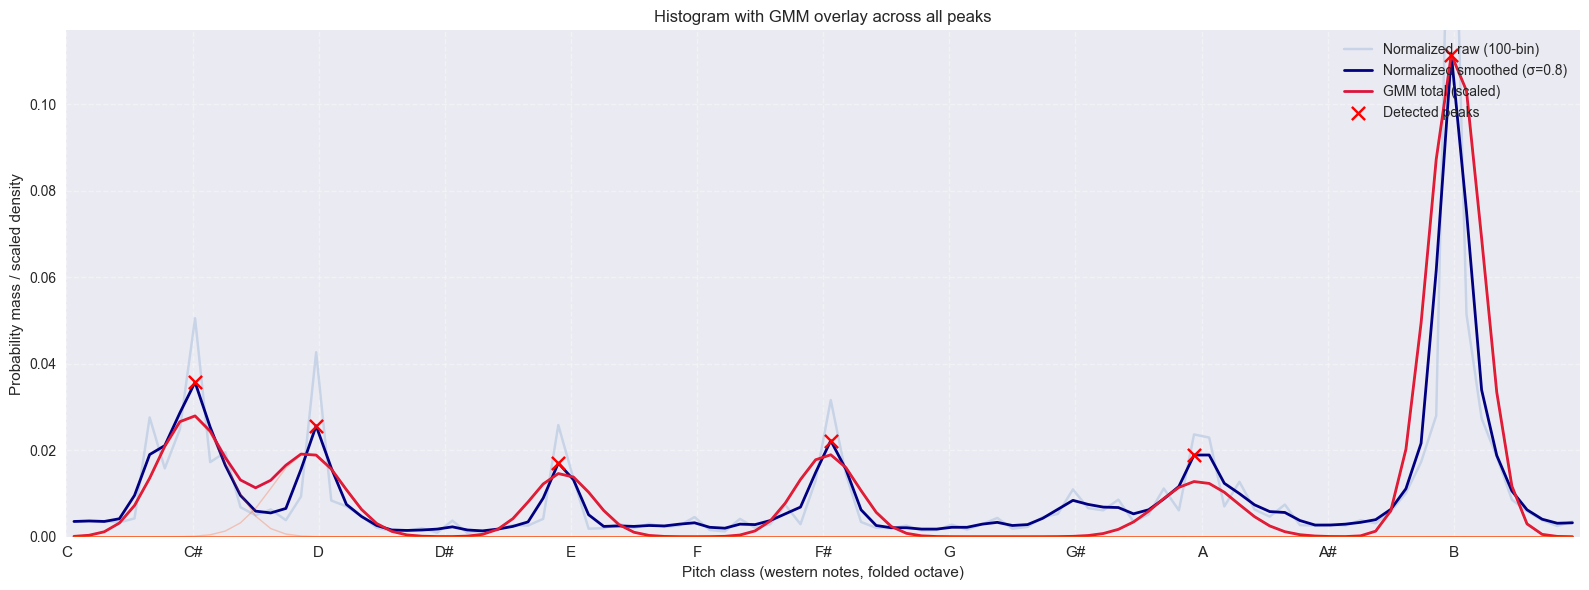


=== Summary of Andolan Analysis ===
Peak characteristics (potential andolan signatures):
----------------------------------------------------------------------
Peak 1: C# region
  Original peak: 102.0¢, Height: 0.0357
  GMM center: 98.8¢ (σ=27.2¢, weight=1.00)
  Deviation from C#: -1.2¢

Peak 2: D region
  Original peak: 198.0¢, Height: 0.0256
  GMM center: 191.6¢ (σ=28.3¢, weight=1.00)
  Deviation from D: -8.4¢

Peak 3: E region
  Original peak: 390.0¢, Height: 0.0170
  GMM center: 393.1¢ (σ=24.7¢, weight=1.00)
  Deviation from E: -6.9¢

Peak 4: F# region
  Original peak: 606.0¢, Height: 0.0222
  GMM center: 603.2¢ (σ=24.9¢, weight=1.00)
  Deviation from F#: +3.2¢

Peak 5: A region
  Original peak: 894.0¢, Height: 0.0189
  GMM center: 897.1¢ (σ=31.4¢, weight=1.00)
  Deviation from A: -2.9¢

Peak 6: B region
  Original peak: 1098.0¢, Height: 0.1115
  GMM center: 1101.1¢ (σ=21.1¢, weight=1.00)
  Deviation from B: +1.1¢


Saved note_gmm_vector_12 (rows C..B; cols: height, deviation, sig

In [24]:
from sklearn.mixture import GaussianMixture
from scipy import stats
import matplotlib.pyplot as plt

# Gaussian Mixture Model fitting for detected peaks to analyze microtonal movements
def fit_gmm_to_peaks(
    smoothed_histogram,
    bin_centers,
    peak_indices,
    n_components_per_peak=1,
    window_width_cents=150,
    plot=True,
    overlay_plot=True,
    debug_per_peak=False,
    base_series_1=None,
    base_label_1='Normalized raw (100-bin)',
    base_series_2=None,
    base_label_2='Normalized smoothed',
    center_reference='peak'  # 'peak' (default) or 'note'
):
    """
    Fit Gaussian Mixture Models around each detected peak to analyze microtonal movements.

    Parameters:
    - smoothed_histogram: The smoothed histogram values (ideally normalized like smoothed_H_100_plot)
    - bin_centers: Cent positions corresponding to histogram bins (e.g., bin_centers_100)
    - peak_indices: Indices of detected peaks (e.g., final_peak_indices_100)
    - n_components_per_peak: Number of Gaussian components to fit per peak region
    - window_width_cents: Width of window around each peak for GMM fitting
    - plot: Enable plotting in general
    - overlay_plot: If True, draw a single full-range plot (0..1200) with base histogram(s) and GMM overlays
    - debug_per_peak: If True, draw detailed 2xN per-peak window plots (can be noisy for many peaks)
    - base_series_1/2: Optional baseline series to overlay (e.g., H_mel_100_norm and smoothed_H_100_plot)
    - center_reference: Controls the reference center used to compute the stored deviation per note.
        'peak' (default) stores deviation from the detected note peak. 'note' stores deviation from the
        ideal 100-cent-spaced note center.

    Returns:
    - gmm_results: List of dictionaries containing GMM parameters for each peak
    - note_gmm_vector_12: A (12, 3) numpy array with (height, deviation_from_reference, sigma) per note
    """

    gmm_results = []
    peak_cents = bin_centers[peak_indices]

    # Initialize 12x3 vector: (height, deviation_from_reference, sigma)
    note_centers = np.arange(0, 1200, 100)
    note_gmm_vector_12 = np.zeros((12, 3), dtype=float)
    note_gmm_vector_12[:] = np.nan  # fill with NaN until populated

    print(f"Fitting GMM to {len(peak_indices)} detected peaks...")
    print("Peak positions (cents):", [f"{cent:.1f}" for cent in peak_cents])

    # Optional per-peak debug plots
    if plot and debug_per_peak and len(peak_indices) > 0:
        cols = min(4, len(peak_indices))
        fig, axes = plt.subplots(2, cols, figsize=(4*cols, 8))
        if cols == 1:
            axes = axes.reshape(2, 1)

    # Collect all GMM components across peaks for global overlay
    all_components = []  # list of dicts: {mu, sigma, weight, peak_height}

    for i, (peak_idx, peak_cent) in enumerate(zip(peak_indices, peak_cents)):
        # Define window around peak (handling circular nature of cents)
        half_window = window_width_cents / 2

        # Bins within window (with wrap-around at 0/1200)
        distances = np.abs(bin_centers - peak_cent)
        distances = np.minimum(distances, 1200 - distances)  # circular distance
        window_mask = distances <= half_window

        if np.sum(window_mask) < 3:  # Need minimum data points
            print(f"Warning: Peak at {peak_cent:.1f}¢ has insufficient data for GMM fitting")
            continue

        # Extract data for this peak region
        window_cents = bin_centers[window_mask]
        window_values = smoothed_histogram[window_mask]

        # Create weighted samples for GMM (repeat each cent value according to its histogram value)
        # Scale values to create reasonable number of samples
        scale_factor = max(1, int(1000 / max(np.sum(window_values), 1e-6)))
        samples = []
        for cent, value in zip(window_cents, window_values):
            n_samples = max(1, int(value * scale_factor))
            samples.extend([cent] * n_samples)

        if len(samples) < 5:  # Minimum samples needed
            print(f"Warning: Peak at {peak_cent:.1f}¢ has too few samples for reliable GMM fitting")
            continue

        X = np.array(samples).reshape(-1, 1)

        # Fit GMM
        try:
            gmm = GaussianMixture(n_components=n_components_per_peak, random_state=42)
            gmm.fit(X)

            # Extract parameters
            means = gmm.means_.flatten()
            covariances = np.sqrt(gmm.covariances_.flatten())  # Standard deviations
            weights = gmm.weights_

            # Sort by weight (most prominent component first)
            sort_idx = np.argsort(weights)[::-1]
            means = means[sort_idx]
            covariances = covariances[sort_idx]
            weights = weights[sort_idx]

            # Calculate peak height from original histogram (normalized smoothed)
            peak_height = float(smoothed_histogram[peak_idx])

            # Store components for global overlay
            for mu, sigma, w in zip(means, covariances, weights):
                all_components.append({
                    'mu': float(mu),
                    'sigma': float(max(sigma, 1e-6)),  # guard against zero
                    'weight': float(w),
                    'peak_height': float(peak_height)
                })

            # Store results per-peak
            peak_result = {
                'original_peak_cent': float(peak_cent),
                'peak_height': peak_height,
                'gmm_means': means.tolist(),
                'gmm_sigmas': covariances.tolist(),
                'gmm_weights': weights.tolist(),
                'log_likelihood': float(gmm.score(X)),
                'n_samples': int(len(samples)),
                'window_range': (float(window_cents.min()), float(window_cents.max()))
            }
            gmm_results.append(peak_result)

            # Map this peak to the nearest note center and record tuple if not already recorded
            diffs_to_notes = np.abs((peak_cent - note_centers + 600) % 1200 - 600)
            nearest_note_idx = int(np.argmin(diffs_to_notes))
            # Use the primary component (highest weight)
            primary_mu = float(means[0])
            primary_sigma = float(covariances[0])

            # Choose reference center (peak by default)
            if str(center_reference).lower() == 'note':
                reference_cent = float(note_centers[nearest_note_idx])
            else:
                reference_cent = float(peak_cent)

            deviation_from_reference = (primary_mu - reference_cent + 600) % 1200 - 600

            # Only set if NaN (first peak mapped to this note wins). If multiple peaks map to same note,
            # keep the one with larger peak_height.
            existing = note_gmm_vector_12[nearest_note_idx]
            if np.isnan(existing[0]) or peak_height > existing[0]:
                note_gmm_vector_12[nearest_note_idx] = np.array([peak_height, deviation_from_reference, primary_sigma])

            # Optional: per-peak debug plots (limit to first 4 columns)
            if plot and debug_per_peak and i < 4:
                x_range = np.linspace(window_cents.min(), window_cents.max(), 200)

                # Top subplot: Original histogram and GMM components
                ax_top = axes[0, i]
                ax_top.plot(window_cents, window_values, 'bo-', alpha=0.7, label='Original (window)')

                gmm_total = np.zeros_like(x_range)
                for j, (mu, sigma, weight) in enumerate(zip(means, covariances, weights)):
                    component = weight * peak_height * stats.norm.pdf(x_range, mu, sigma)
                    gmm_total += component
                    ax_top.plot(x_range, component, '--', alpha=0.8,
                                label=f'C{j+1}: μ={mu:.1f}¢, σ={sigma:.1f}¢')

                ax_top.plot(x_range, gmm_total, 'r-', linewidth=2, label='GMM Total')
                ax_top.axvline(peak_cent, color='red', linestyle=':', alpha=0.7, label='Original peak')
                ax_top.set_title(f'Peak @ {peak_cent:.1f}¢ | H={peak_height:.3f}')
                ax_top.set_xlabel('Cents')
                ax_top.set_ylabel('Normalized intensity')
                ax_top.legend(fontsize=8)
                ax_top.grid(True, alpha=0.3)

                # Bottom subplot: Residuals
                ax_bottom = axes[1, i]
                gmm_interp = np.interp(window_cents, x_range, gmm_total)
                residuals = window_values - gmm_interp
                ax_bottom.plot(window_cents, residuals, 'go-', alpha=0.7)
                ax_bottom.axhline(0, color='red', linestyle='-', alpha=0.5)
                ax_bottom.set_title('Residuals (Original - GMM)')
                ax_bottom.set_xlabel('Cents')
                ax_bottom.set_ylabel('Residual')
                ax_bottom.grid(True, alpha=0.3)

            # Console summary
            print(f"Peak at {peak_cent:.1f}¢:")
            for j, (mu, sigma, weight) in enumerate(zip(means, covariances, weights)):
                print(f"  Component {j+1}: μ={mu:.2f}¢, σ={sigma:.2f}¢, weight={weight:.3f}")
            print(f"  Log-likelihood: {gmm.score(X):.2f}\n")

        except Exception as e:
            print(f"Error fitting GMM to peak at {peak_cent:.1f}¢: {e}")
            continue

    if plot and debug_per_peak and len(peak_indices) > 0:
        plt.tight_layout()
        plt.show()

    # Single full-range overlay plot (0..1200) with base histogram(s) and all GMMs
    if plot and overlay_plot and len(all_components) > 0:
        x_full = bin_centers
        gmm_sum = np.zeros_like(x_full, dtype=float)
        component_curves = []  # for optional individual component overlays

        # Build unscaled GMM sum
        for comp in all_components:
            mu = comp['mu']
            sigma = comp['sigma']
            w = comp['weight']
            peak_h = comp['peak_height']
            curve = w * peak_h * stats.norm.pdf(x_full, mu, sigma)
            component_curves.append(curve)
            gmm_sum += curve

        # Scale GMM curves to be visually comparable to the smoothed histogram
        target_max = float(np.max(smoothed_histogram)) if np.max(smoothed_histogram) > 0 else 1.0
        current_max = float(np.max(gmm_sum)) if np.max(gmm_sum) > 0 else 1.0
        scale = target_max / current_max
        gmm_sum_scaled = gmm_sum * scale
        component_curves_scaled = [c * scale for c in component_curves]

        # Compose overlay plot
        plt.figure(figsize=(16, 6))

        # Base series: show raw-normalized and smoothed if available
        drew_any_base = False
        if base_series_1 is not None:
            plt.plot(bin_centers, base_series_1, color='lightsteelblue', alpha=0.6, label=base_label_1)
            drew_any_base = True
        if base_series_2 is not None:
            plt.plot(bin_centers, base_series_2, color='navy', linewidth=2, label=base_label_2)
            drew_any_base = True
        if not drew_any_base:
            # Fallback: draw the smoothed_histogram on its own
            plt.plot(bin_centers, smoothed_histogram, color='navy', linewidth=2, label='Smoothed (norm)')

        # Overlay: combined GMM sum
        plt.plot(x_full, gmm_sum_scaled, color='crimson', linewidth=2, label='GMM total (scaled)')

        # Optionally overlay individual components (limit to avoid clutter)
        max_components_to_draw = 24
        if len(component_curves_scaled) <= max_components_to_draw:
            for c in component_curves_scaled:
                plt.plot(x_full, c, color='orangered', alpha=0.25, linewidth=1)
        else:
            # Too many components; skip detailed component overlay
            pass

        # Show detected peak markers
        if len(peak_indices) > 0:
            peak_x = bin_centers[peak_indices]
            peak_y = smoothed_histogram[peak_indices]
            plt.scatter(peak_x, peak_y, color='red', s=90, marker='x', zorder=5, label='Detected peaks')

        # Cosmetic settings matching earlier plots
        xticks_positions = np.arange(0, 1200, 100)
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        plt.xticks(ticks=xticks_positions, labels=note_names, fontsize=11)
        plt.xlim(0, 1200)
        ymax = max(float(np.max(smoothed_histogram)) * 1.05, 0.01)
        plt.ylim(0, ymax)
        plt.xlabel('Pitch class (western notes, folded octave)')
        plt.ylabel('Probability mass / scaled density')
        plt.title('Histogram with GMM overlay across all peaks')
        plt.grid(True, linestyle='--', alpha=0.35)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return gmm_results, note_gmm_vector_12

# Apply GMM fitting to detected peaks with full overlay plot
if 'final_peak_indices_100' in globals() and 'smoothed_H_100_plot' in globals():
    print("=== Gaussian Mixture Model Analysis for Andolan Detection ===")
    print("Analyzing microtonal movements around detected peaks...\n")

    gmm_results, note_gmm_vector_12 = fit_gmm_to_peaks(
        smoothed_histogram=smoothed_H_100_plot,
        bin_centers=bin_centers_100,
        peak_indices=final_peak_indices_100,
        n_components_per_peak=1,  # Start with single Gaussian per peak
        window_width_cents=120,   # Analyze ±60 cents around each peak
        plot=True,
        overlay_plot=True,
        debug_per_peak=False,     # Turn on to see per-peak window diagnostics
        base_series_1=H_mel_100_norm if 'H_mel_100_norm' in globals() else None,
        base_label_1='Normalized raw (100-bin)',
        base_series_2=smoothed_H_100_plot,
        base_label_2=f'Normalized smoothed (σ={sigma})',
        center_reference='peak'  # default; set to 'note' to compute deviation from note centers
    )

    # Make it globally available for downstream cells
    globals()['note_gmm_vector_12'] = note_gmm_vector_12

    # Summary analysis
    if gmm_results:
        print("\n=== Summary of Andolan Analysis ===")
        print("Peak characteristics (potential andolan signatures):")
        print("-" * 70)

        note_centers = np.arange(0, 1200, 100)
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

        for i, result in enumerate(gmm_results):
            original_cent = result['original_peak_cent']
            height = result['peak_height']

            # Primary component (highest weight)
            primary_mu = result['gmm_means'][0]
            primary_sigma = result['gmm_sigmas'][0]
            primary_weight = result['gmm_weights'][0]

            # Calculate deviation from expected note center
            deviations = np.abs((original_cent - note_centers + 600) % 1200 - 600)
            nearest_note_idx = int(np.argmin(deviations))
            expected_cent = float(note_centers[nearest_note_idx])
            note_name = note_names[nearest_note_idx]

            deviation_from_note = (primary_mu - expected_cent + 600) % 1200 - 600

            print(f"Peak {i+1}: {note_name} region")
            print(f"  Original peak: {original_cent:.1f}¢, Height: {height:.4f}")
            print(f"  GMM center: {primary_mu:.1f}¢ (σ={primary_sigma:.1f}¢, weight={primary_weight:.2f})")
            print(f"  Deviation from {note_name}: {deviation_from_note:+.1f}¢")

            # --- Andolan analysis disabled by request ---
            # if primary_sigma < 8:
            #     andolan_type = "Very stable (minimal andolan)"
            # elif primary_sigma < 15:
            #     andolan_type = "Stable with slight movement"
            # elif primary_sigma < 25:
            #     andolan_type = "Moderate andolan activity"
            # elif primary_sigma < 40:
            #     andolan_type = "Strong andolan/oscillation"
            # else:
            #     andolan_type = "Very wide spread (possible multiple notes or strong andolan)"
            # print(f"  Andolan signature: {andolan_type}")

            # Significant deviation (possible shruti variations)
            if abs(deviation_from_note) > 20:
                print(f"  *** Significant deviation detected - possible shruti variation ***")
            print()

        # --- Overall andolan summary disabled by request ---
        # all_sigmas = [res['gmm_sigmas'][0] for res in gmm_results if len(res['gmm_sigmas'])]
        # if len(all_sigmas):
        #     avg_sigma = np.mean(all_sigmas)
        #     print(f"Average sigma across all peaks: {avg_sigma:.1f}¢")
        #     if avg_sigma < 15:
        #         print("Overall style: Relatively stable intonation")
        #     elif avg_sigma < 25:
        #         print("Overall style: Moderate use of andolans and microtonal movements")
        #     else:
        #         print("Overall style: Extensive use of andolans and expressive intonation")
        # else:
        #     print("Insufficient GMM results for overall analysis.")

    # Print a concise summary of the 12x3 vector
    if 'note_gmm_vector_12' in globals():
        print("\nSaved note_gmm_vector_12 (rows C..B; cols: height, deviation, sigma):")
        with np.printoptions(precision=3, suppress=True):
            print(note_gmm_vector_12)

else:
    print("Error: Required variables not found. Please run the peak detection cell first.")